In [1]:
import numpy as np
import pandas as pd

from sklearn.utils._testing import ignore_warnings
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import ConvergenceWarning

In [2]:
# Ref: July 1988, https://www.slac.stanford.edu/pubs/slacpubs/4250/slac-pub-4389.pdf 

class RegularizedDiscriminantAnalysis(BaseEstimator):

    def __init__(self, alpha=1e-5, gamma=1e-5):
        self.alpha = alpha  # Regularization
        self.gamma = gamma  # Regularization
        self.w = None
        self.means = None
        self.S_k = None
        self.W_k = None
        self.sigma = None
        self.class_labels = None
    

    def fit(self, X, y):
        n_samples, n_features = X.shape
        class_labels = np.unique(y)
        n_classes = len(class_labels)
        
        # Store class labels
        self.class_labels = class_labels
        self.means = {}
        self.W_k = []
        self.S_k = np.zeros((n_features, n_features))
        self.sigma = np.zeros((n_features, n_features))
        
        # Compute mean for each class
        mean_overall = np.mean(X, axis=0)
        
        for c in class_labels:
            X_c = X[y == c]  # Samples with label c
            n_c = X_c.shape[0]
            mean_c = np.mean(X_c, axis=0)
            self.means[c] = mean_c
            
            # Within-class scatter matrix sigma_k
            diff = X_c - mean_c
            self.S_k += 1 / n_c * np.dot(diff.T, diff)
            
            # Between-class scatter matrix sigma
            diff_mean = (mean_c - mean_overall).reshape(n_features, 1)
            self.sigma += n_c * np.dot(diff_mean, diff_mean.T)

        # Regularization
        # Regularize the within-class scatter matrix S_k
        # Shrink towards pooled covariance (W_k)
        pooled_covariance = self.S_k / n_samples  # pooled estimate
        self.S_k = (1 - self.alpha) * self.S_k + self.alpha * pooled_covariance

        # Apply gamma regularization: shrink towards the identity matrix
        if self.gamma > 0:
            # Compute the trace of the within-class covariance
            trace_S_k = np.trace(self.S_k)
            identity_matrix = np.eye(n_features)
            
            # Apply shrinkage towards the identity matrix
            self.S_k = (1 - self.gamma) * self.S_k + (self.gamma / n_features) * trace_S_k * identity_matrix
        
        # Solve the generalized eigenvalue problem
        eigvals, eigvecs = np.linalg.eig(np.linalg.inv(self.S_k).dot(self.sigma))
        
        # Sort eigenvectors by eigenvalues
        idx = eigvals.argsort()[::-1]
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:, idx]
        
        # Use all eigenvectors corresponding to non-zero eigenvalues (for multi-class)
        self.w = eigvecs[:, :n_classes - 1]
    
    
    def predict(self, X):
        # Project data onto LDA components
        X_projected = X.dot(self.w)
        
        # Project class means onto the LDA space
        means_projected = {c: self.w.T.dot(self.means[c]) for c in self.class_labels}
        
        # For each sample, predict the class by finding the closest projected class mean
        predictions = []
        for x_proj in X_projected:
            distances = [np.linalg.norm(x_proj - means_projected[c]) for c in self.class_labels]
            predicted_class = self.class_labels[np.argmin(distances)]
            predictions.append(predicted_class)
        
        return np.array(predictions)

In [3]:
from load_datasets import load_dataset

@ignore_warnings(category=ConvergenceWarning)
def test_rda(dataset: str = "iris"):
    print("=============================")
    print(f"dataset: {dataset}")
    X, y = load_dataset[dataset](return_X_y=True)
    X = pd.DataFrame(X)
    X = X.select_dtypes(include='number').values  # Brute method (ignoring categorical features) is used for simplicity
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    RDA = RegularizedDiscriminantAnalysis()
    param_grid_rda = {
        'alpha': [0, 0.1, 0.5, 1],
        'gamma': [0, 0.1, 0.5, 1]
    }
    grid_search_rda = GridSearchCV(estimator=RDA, param_grid=param_grid_rda, cv=5, scoring='accuracy')


    grid_search_rda.fit(X_train, y_train)
    y_pred_rda = grid_search_rda.best_estimator_.predict(X_test)
    accuracy_rda = round(accuracy_score(y_test, y_pred_rda), 3)
    print(f"RDA, best parameters: {grid_search_rda.best_params_}")
    print(f"RDA, accuracy: {accuracy_rda}")
    
    # Logistic Regression
    LogReg = LogisticRegression(max_iter=1000)
    param_grid_logreg = {
        'C': [0.01, 0.1, 1, 10],  # Regularization strength
        'solver': ['lbfgs', 'liblinear'],
        'penalty': ['l2']
    }
    grid_search_logreg = GridSearchCV(estimator=LogReg, param_grid=param_grid_logreg, cv=5, scoring='accuracy')
    grid_search_logreg.fit(X_train, y_train)
    y_pred_logreg = grid_search_logreg.best_estimator_.predict(X_test)
    accuracy_logreg = round(accuracy_score(y_test, y_pred_logreg), 3)
    print(f"LogReg, best parameters: {grid_search_logreg.best_params_}")
    print(f"LogReg, accuracy: {accuracy_logreg}")

In [4]:
for key in load_dataset.keys():
    test_rda(dataset=key)
print("=============================")

dataset: wine
RDA, best parameters: {'alpha': 0, 'gamma': 0}
RDA, accuracy: 1.0
LogReg, best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
LogReg, accuracy: 1.0
dataset: iris
RDA, best parameters: {'alpha': 0, 'gamma': 0}
RDA, accuracy: 1.0
LogReg, best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
LogReg, accuracy: 1.0
dataset: breast_cancer
RDA, best parameters: {'alpha': 0, 'gamma': 0}
RDA, accuracy: 0.974
LogReg, best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
LogReg, accuracy: 0.956
dataset: students_dropout_and_academic_success
RDA, best parameters: {'alpha': 0, 'gamma': 0}
RDA, accuracy: 0.706
LogReg, best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
LogReg, accuracy: 0.755
dataset: adult
RDA, best parameters: {'alpha': 0, 'gamma': 0.1}
RDA, accuracy: 0.788
LogReg, best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
LogReg, accuracy: 0.815
dataset: bank_marketing
RDA, best parameters: {'alpha': 0, 'gamma': 0.1}

RDA showed better performance than Logistic Regression on the ```breast_cancer``` dataset, because:
- The dataset is small.
- The features roughly follow a normal distribution for each class.
- The features might be correlated.

### Let's verify these claims

In [5]:
X, y = load_dataset["breast_cancer"](return_X_y=True)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro

In [7]:
# 1. Check the size of the dataset
num_samples, num_features = X.shape
print(f"Number of samples: {num_samples}, Number of features: {num_features}")

Number of samples: 569, Number of features: 30


Shapiro-Wilk test for feature 0 and class 1: p-value = 0.6679930583301221


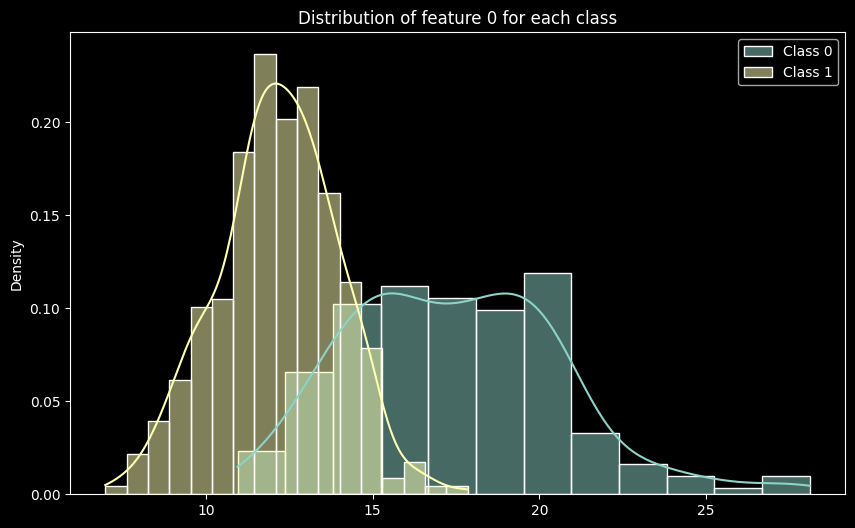

Shapiro-Wilk test for feature 2 and class 1: p-value = 0.7794937940236659


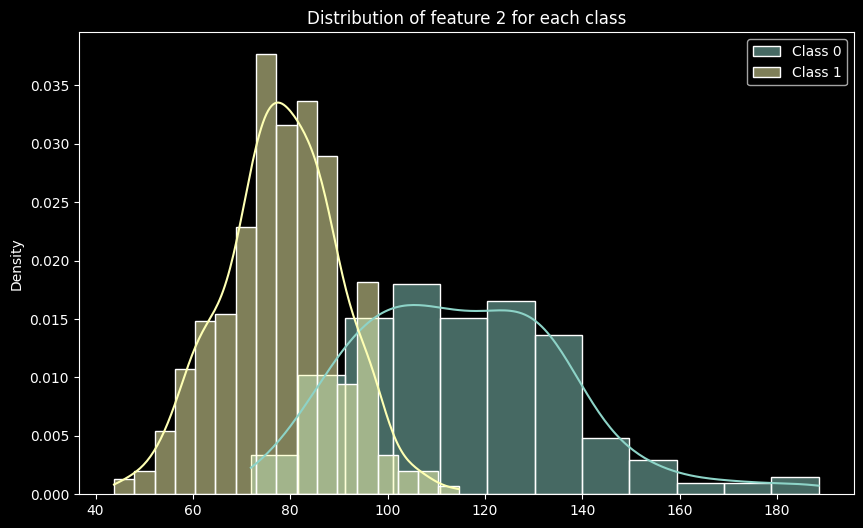

Shapiro-Wilk test for feature 20 and class 1: p-value = 0.6944035741779517


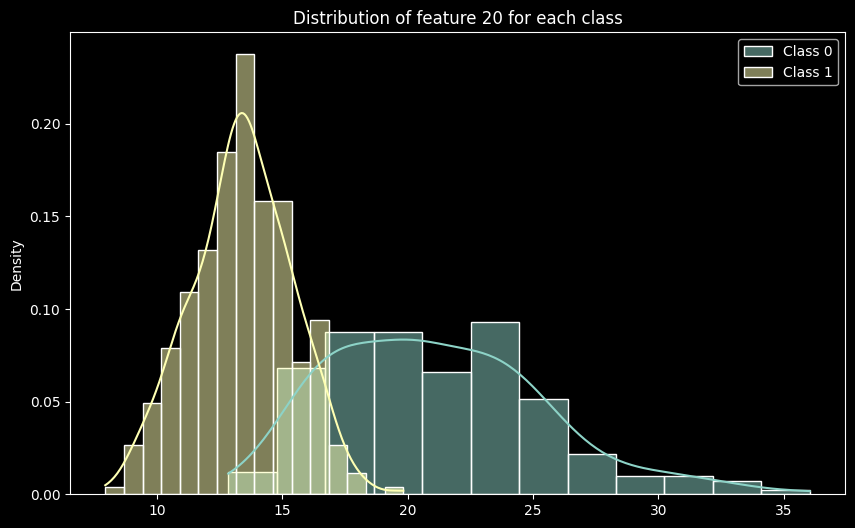

Shapiro-Wilk test for feature 22 and class 1: p-value = 0.7116704121383973


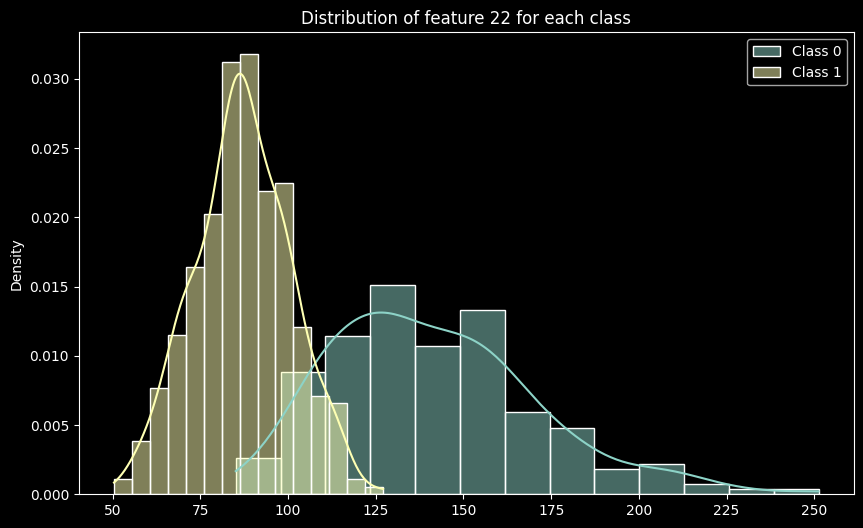

Shapiro-Wilk test for feature 27 and class 0: p-value = 0.5868377906620755


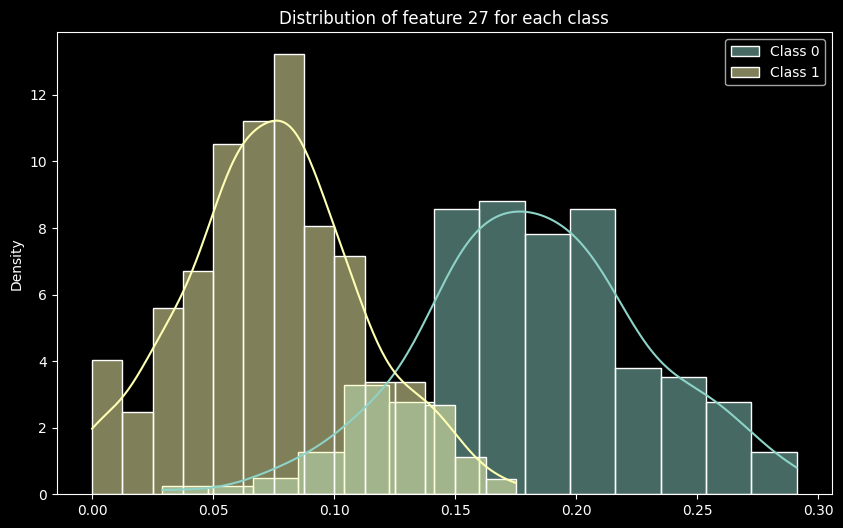

Shapiro-Wilk test for feature 28 and class 1: p-value = 0.2261965083711454


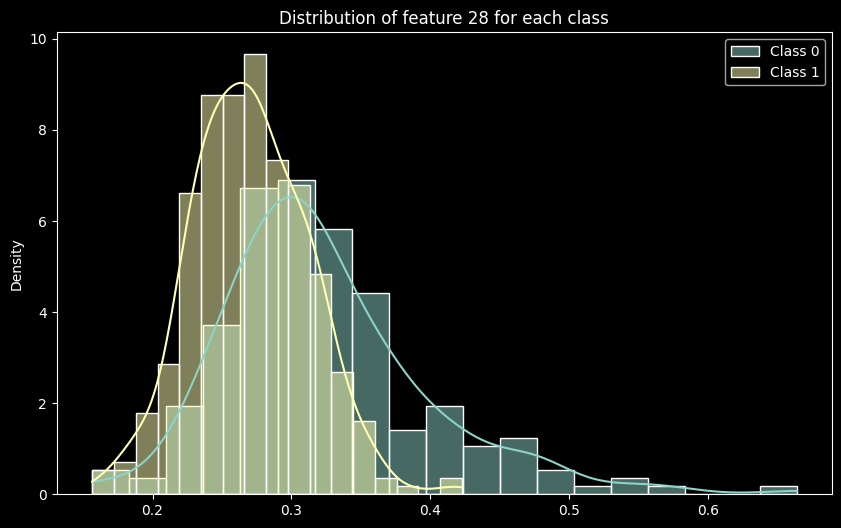

In [8]:
# 2. Check if features follow a normal distribution for each class (using the Shapiro-Wilk test for normality)
classes = np.unique(y)

# Plot histograms of features for each class
for feature in range(num_features):
    normal = False
    for c in classes:
        _, p_value = shapiro(X[y == c, feature])
        if p_value >= 0.05:
            normal = True
            print(f"Shapiro-Wilk test for feature {feature} and class {c}: p-value = {p_value}")
    if normal:
        plt.figure(figsize=(10, 6))
        for c in classes:
            sns.histplot(X[y == c, feature], kde=True, label=f'Class {c}', stat='density')
        plt.title(f"Distribution of feature {feature} for each class")
        plt.legend()
        plt.show()

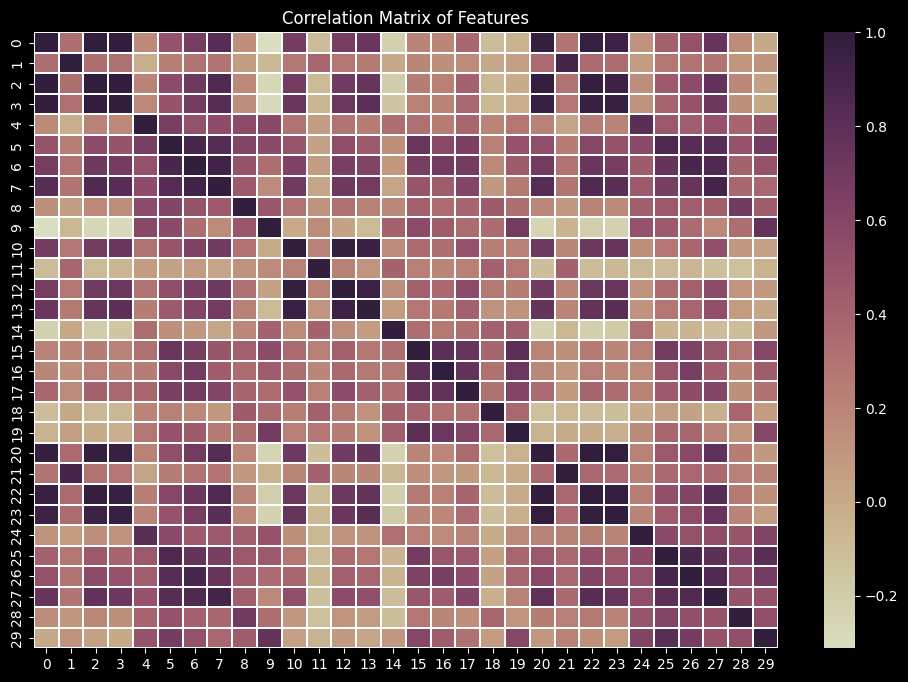

In [9]:
# 3. Check for high correlations between features
correlation_matrix = pd.DataFrame(X).corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap=sns.color_palette("ch:s=-.0,r=.6", as_cmap=True), fmt='.2f', linewidths=0.01)
plt.title("Correlation Matrix of Features")
plt.show()

# Conclusion: 

### Data is correlated (bad for LogReg) and the classes are normally distributed (good for LDA)